In [10]:
import copy
import numpy as np
import pandas as pd
import qiime2 as q2
from biom import Table
from scipy.stats import ttest_ind
from skbio import OrdinationResults
from qiime2.plugins.deicode.actions import rpca
from qiime2.plugins.emperor.actions import biplot, plot

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [2]:
pthwy_abund = pd.read_csv('data/metagenomics/pathway-gene/pathway-abundance.tsv',
                        sep='\t', index_col=0)
pthwy_expression = pd.read_csv('data/metagenomics/pathway-gene/pathway-expression.tsv',
                        sep='\t', index_col=0)

# rename Carbohydrate_degradation;pentose_phosphate_pathway_(non_oxidative_stage);....
rnm1 = {x:';'.join(x.split(';')[:2])+ '(non-oxidative_stage)' + ';' + ';'.join(x.split(';')[2:])
        for x in pthwy_expression.index if 'pentose_phosphate_pathway' in x if 'non-oxidative_stage' in x}
# rename Carbohydrate_degradation;pentose_phosphate_pathway_(oxidative_stage);....
rnm2 = {x:';'.join(x.split(';')[:2])+ '(oxidative_stage)' + ';' + ';'.join(x.split(';')[2:])
        for x in pthwy_expression.index if 'pentose_phosphate_pathway' in x if '(oxidative_stage' in x}
# merge
rnm = {**rnm1, **rnm2}
pthwy_expression = pthwy_expression.rename(rnm, axis=0)
pthwy_abund = pthwy_abund.rename(rnm, axis=0)

mf = pd.DataFrame([x.split('_')[0] 
                   for x in pthwy_expression.columns],
                  pthwy_expression.columns,['treatment'])
mf.index.name = '#SampleID'
q2mf = q2.Metadata(mf)
mf

,treatment
#SampleID,
Control_3_S6,Control
Control_1_S4,Control
Alcohol_2_S2,Alcohol
Alcohol_1_S1,Alcohol
Control_2_S5,Control
Alcohol_3_S3,Alcohol


In [3]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import minmax_scale

def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    sc = ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    num_ = 7
    
    labels = [int(v[14:][:-2])/size_scale
             for v in sc.legend_elements("sizes", num=num_)[1]]
    labels = np.around(minmax_scale(labels, (size_min, size_max)), 2)

    labels =  [str(l) for l in labels]
    handles = sc.legend_elements("sizes", num=num_)[0]
    legend_ = ax.legend(handles[:],labels[:],
                prop={'size':23}, loc=2, 
                handletextpad=0.1,
                bbox_to_anchor=(-0.25, 1.2),
                fancybox=True, framealpha=0.1,ncol=3
                , facecolor="white",
                edgecolor='black')
    
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45,
                       horizontalalignment='right',
                       color='black')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num],
                       color='black')

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # remove all grids, backrounds etc ...
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 
        

def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )

    

In [4]:

def bin_pathway_level(df, level=2, direction=True):
    
    # check level
    df = df.loc[[len(i.split(';')) > 1 for i in df.index], :]
    df.index = [' : '.join([x.split('_via')[0]
                            for x in ind.split(';')[:level]]).replace('_[regulation].','').lstrip().lstrip()
                                 for ind in df.index]
    if not direction:
        df.index = [ind.replace('_degradation','').replace('_biosynthesis','')
                    for ind in df.index]
    
    
    df = df.groupby(df.index).sum()
    df_tpm = (df * 100 /df.sum())
    df_tpm_log2 = pd.DataFrame(np.log2(df_tpm.values + 1),
                               df_tpm.index,
                               df_tpm.columns)
    return df, df_tpm, df_tpm_log2



# bin by a level
abund_lvl, abund_lvl_tpm, abund_lvl_log2 = bin_pathway_level(pthwy_abund.copy())
expression_lvl, expressionlvl_tpm, expression_lvl_log2 = bin_pathway_level(pthwy_expression.copy())

# stack Abundance 
pathwy_plot = abund_lvl_log2.stack().reset_index()
pathwy_plot.columns = ['Pathway','Sample','Abundance']
# add Expression
stacked_exp = expression_lvl_log2.stack().reset_index()
stacked_exp.index = stacked_exp['level_0'] + '-' + stacked_exp['#SampleID']
stacked_exp = stacked_exp.reindex(pathwy_plot['Pathway'] + '-' + pathwy_plot['Sample'])
pathwy_plot['Expression'] = stacked_exp[0].values
# view
pathwy_plot.head(5)

,Pathway,Sample,Abundance,Expression
0,Alcohol_metabolism : butanol_biosynthesis.,Control_3_S6,0.065150,0.082613
1,Alcohol_metabolism : butanol_biosynthesis.,Control_1_S4,0.028978,0.053729
2,Alcohol_metabolism : butanol_biosynthesis.,Alcohol_2_S2,0.036136,0.103572
3,Alcohol_metabolism : butanol_biosynthesis.,Alcohol_1_S1,0.033481,0.167235
4,Alcohol_metabolism : butanol_biosynthesis.,Control_2_S5,0.023874,0.134967


In [5]:
pathwy_plot.describe()

,Abundance,Expression
count,2796.000000,2796.000000
mean,0.236651,0.248903
std,0.323540,0.280561
min,0.000000,0.000000
25%,0.029734,0.054707
50%,0.112480,0.160484
75%,0.298613,0.335146
max,2.696828,1.887088


In [6]:
def bin_pathway_level(df, level=2, direction=True):
    
    # check level
    df = df.loc[[len(i.split(';')) > 1 for i in df.index], :]
    df.index = [' : '.join([x.split('_via')[0]
                            for x in ind.split(';')[:level]]).replace('_[regulation].','').lstrip().lstrip()
                                 for ind in df.index]
    if not direction:
        df.index = [ind.replace('_degradation','').replace('_biosynthesis','').replace('_',' ').replace('.','')
                    if 'bile' not in ind
                    else
                    ind.replace('_degradation','').replace('_',' ').replace('.','')
                    for ind in df.index]
    else:
        df.index = [ind.replace('_',' ').replace('.','')
                    for ind in df.index]        
    # filt
    replace_me = {' and dicarboxylate metabolism':' cycle',
                'glycerol fermentation':'glycerol',
                'pentose phosphate pathway':'PPP',
                'tricarboxylic acid cycle':'TCA',
                 'fatty acid biosynthesis':'short-chain fatty acid biosynthesis',
                 'short-chain fatty acid metabolism':'short-chain fatty acid biosynthesis'}
                #'fatty acid beta-oxidation':'short-chain fatty acid',
                #'fatty acid metabolism':'fatty acid'}
    for k1, k2 in replace_me.items():
        df.index = [ind.replace(k1,k2) for ind in df.index]
    

    df = df.groupby(df.index).sum()
    df_tpm = (df * 100 /df.sum())
    df_tpm_log2 = pd.DataFrame(np.log2(df_tpm.values + 1),
                               df_tpm.index,
                               df_tpm.columns)
    return df, df_tpm, df_tpm_log2



# bin by a level
abund_lvl, abund_lvl_tpm, abund_lvl_log2 = bin_pathway_level(pthwy_abund.copy())
expression_lvl, expressionlvl_tpm, expression_lvl_log2 = bin_pathway_level(pthwy_expression.copy())

# stack Abundance 
pathwy_plot = abund_lvl_log2.stack().reset_index()
pathwy_plot.columns = ['Pathway','Sample','Abundance']
# add Expression
stacked_exp = expression_lvl_log2.stack().reset_index()
stacked_exp.index = stacked_exp['level_0'] + '-' + stacked_exp['#SampleID']
stacked_exp = stacked_exp.reindex(pathwy_plot['Pathway'] + '-' + pathwy_plot['Sample'])
pathwy_plot['Expression'] = stacked_exp[0].values
# fix sample names
pathwy_plot['Sample'] = [' '.join(x.split('_')[:2]) for x in pathwy_plot.Sample]
# split the pathway to sort
pathwy_plot['Pathway_Group'] = [x.split(' : ')[0] for x in pathwy_plot.Pathway]
pathwy_plot['Pathway'] = [x.split(' : ')[1] for x in pathwy_plot.Pathway]
pathwy_plot = pathwy_plot.sort_values('Pathway_Group', ascending=True)
pathwy_plot = pathwy_plot.replace('pyruvate fermentation',
                                  'pyruvate fermentation to acetate')
pathwy_plot = pathwy_plot.replace('Glycan','Glycan metabolism')
pathwy_plot = pathwy_plot.replace('acetyl-CoA biosynthesis',
                                  'acetyl-CoA from acetate')
pathwy_plot = pathwy_plot.replace('ethanol degradation',
                                  'acetate from ethanol')
# view
pathwy_plot.head(5)

,Pathway,Sample,Abundance,Expression,Pathway_Group
0,butanol biosynthesis,Control 3,0.065150,0.082613,Alcohol metabolism
17,acetate from ethanol,Alcohol 3,0.142827,0.117862,Alcohol metabolism
16,acetate from ethanol,Control 2,0.204497,0.083982,Alcohol metabolism
15,acetate from ethanol,Alcohol 1,0.123729,0.147835,Alcohol metabolism
14,acetate from ethanol,Alcohol 2,0.239060,0.150331,Alcohol metabolism


In [7]:
# fatty acid biosynthesis:short-chain fatty acid metabolism
# bin for the heat map
heat_map_bins = {'Alcohol Deg.':{'Alcohol metabolism':('acetate from ethanol',),
                                'Polyol metabolism':('glycerol degradation',)},
                'Carbohydrate Metabolism':{'Carbohydrate metabolism':('lactose degradation',
                                                                      'L-rhamnose metabolism'),
                                           'Metabolic intermediate biosynthesis':('acetyl-CoA from acetate',)},
                'C1 metabolism':{'One-carbon metabolism':('formaldehyde assimilation',
                                                         'methanogenesis from CO(2)',
                                                         'methanogenesis from acetate')},
                'Fermentation':{'Fermentation':('pyruvate fermentation to acetate',
                                                'pyruvate fermentation to lactate')},
                'Central Metabolism':{'Carbohydrate biosynthesis':('gluconeogenesis',),
                                      'Carbohydrate degradation':('PPP(non-oxidative stage)',
                                                                  'PPP(oxidative stage)',
                                                                  'glycolysis'),
                                      'Carbohydrate metabolism':('TCA',
                                                                 'glyoxylate cycle',
                                                                'pyruvate metabolism'),
                                      'Glycan degradation':('glycogen degradation',)},
                'Lipid metabolism':{'Lipid metabolism':('bile acid biosynthesis',
                                                        'short-chain fatty acid biosynthesis',
                                                        'fatty acid metabolism',
                                                       'fatty acid biosynthesis',
                                                       'fatty acid beta-oxidation')},
                 'Endotoxins':{'Siderophore biosynthesis':(),
                               'Mycotoxin biosynthesis':()},
                'Nitrogen':{'Nitrogen metabolism':()},
                'Sulfur':{'Sulfur metabolism':()}}
# bin
binned_heatmap = {}
for major_group, minor_groups in heat_map_bins.items():
    for minor_id, sub_groups in minor_groups.items():
        if len(sub_groups) > 0:
            for sub_ in sub_groups:
                binned_heatmap[major_group, minor_id, sub_] = pathwy_plot[pathwy_plot.Pathway_Group.isin([minor_id]) &\
                                                                          pathwy_plot.Pathway.isin([sub_])].groupby('Sample').mean()
        else:
            binned_heatmap[major_group, minor_id, minor_id] = pathwy_plot[pathwy_plot.Pathway_Group.isin([minor_id])].groupby('Sample').mean()

            
binned_heatmap = pd.concat(binned_heatmap).reset_index().drop('level_1', axis=1)
binned_heatmap = binned_heatmap.rename({'level_0':'Pathway_Group','level_2':'Pathway'}, axis=1)
binned_heatmap = binned_heatmap.sort_values('Pathway_Group', ascending=True)
binned_heatmap.head(5)



,Pathway_Group,Pathway,Sample,Abundance,Expression
0,Alcohol Deg.,acetate from ethanol,Alcohol 1,0.123729,0.147835
11,Alcohol Deg.,glycerol degradation,Control 3,0.709363,0.350550
10,Alcohol Deg.,glycerol degradation,Control 2,0.357067,0.315680
8,Alcohol Deg.,glycerol degradation,Alcohol 3,0.297793,0.378375
7,Alcohol Deg.,glycerol degradation,Alcohol 2,0.229257,0.304140


In [8]:
{k:set(df.Pathway) for k,df in binned_heatmap.groupby('Pathway_Group')}

{'Alcohol Deg.': {'acetate from ethanol', 'glycerol degradation'},
 'C1 metabolism': {'formaldehyde assimilation',
  'methanogenesis from CO(2)',
  'methanogenesis from acetate'},
 'Carbohydrate Metabolism': {'L-rhamnose metabolism',
  'acetyl-CoA from acetate',
  'lactose degradation'},
 'Central Metabolism': {'PPP(non-oxidative stage)',
  'PPP(oxidative stage)',
  'TCA',
  'gluconeogenesis',
  'glycogen degradation',
  'glycolysis',
  'glyoxylate cycle',
  'pyruvate metabolism'},
 'Endotoxins': {'Mycotoxin biosynthesis', 'Siderophore biosynthesis'},
 'Fermentation': {'pyruvate fermentation to acetate',
  'pyruvate fermentation to lactate'},
 'Lipid metabolism': {'bile acid biosynthesis',
  'fatty acid beta-oxidation',
  'fatty acid metabolism',
  'short-chain fatty acid biosynthesis'},
 'Nitrogen': {'Nitrogen metabolism'},
 'Sulfur': {'Sulfur metabolism'}}

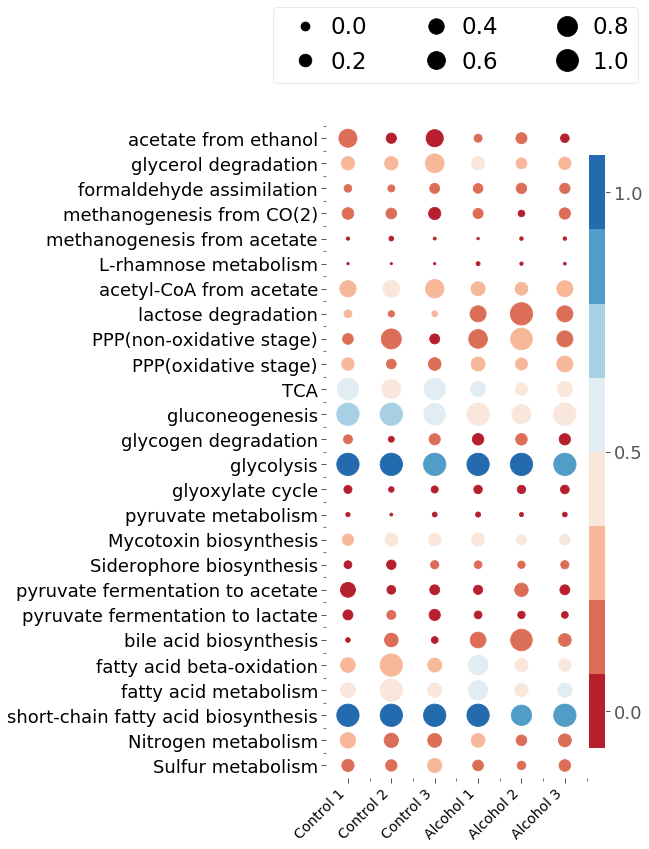

In [11]:
plt.style.use('ggplot')
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 25}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 18

plt.figure(figsize=(5, 12))


y_ord = [k2 for k, df in binned_heatmap.groupby('Pathway_Group')
         for k2 in sorted(set(df.Pathway))]

heatmap(y=binned_heatmap['Pathway'],
        x=binned_heatmap['Sample'],
        color=binned_heatmap['Expression'],
        size=binned_heatmap['Abundance'],
        size_scale=500,
        size_range=(0,1),
        color_range=(0, 1),
        marker='o',
        palette=sns.color_palette("RdBu", 8),
        x_order=['Control 1', 'Control 2', 'Control 3',
                 'Alcohol 1', 'Alcohol 2', 'Alcohol 3'],
        y_order=y_ord[::-1])

# save the figure to file
plt.savefig('results/plots/pathway-summary.pdf',dpi=600, 
            bbox_inches='tight',
            edgecolor='none')

plt.show()